In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [13]:
mg_ml = pd.read_csv('mg_ml_rescaled.csv')

In [14]:
mg_ml = mg_ml.drop(columns=list(mg_ml.columns)[0], axis=1)

In [15]:
Y = mg_ml['default_status']
X = mg_ml.drop(columns=['default_status'], axis=1)

## Modeling 

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Stratified split of the train and test set with train-test ratio of 7.5:2.5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, 
                                            stratify=Y, random_state=10)

In [17]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier

# See the inital model performance
clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
clf.fit(X_train, Y_train)
print('Acc:', cross_val_score(clf, X_train, Y_train, 
                              cv=StratifiedKFold(n_splits=5), 
                              scoring='accuracy').mean())
print('F1:', cross_val_score(clf, X_train, Y_train, 
                             cv=StratifiedKFold(n_splits=5), 
                             scoring='f1').mean())
print('ROC AUC:', cross_val_score(clf, X_train, Y_train, 
                                  cv=StratifiedKFold(n_splits=5), 
                                  scoring='roc_auc').mean())

Acc: 0.7362399999999999
F1: 0.4952492768728664
ROC AUC: 0.7588861213447957


## Fine Tune using F1

In [18]:
#Grid Search
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

clf = GridSearchCV(clf, param_grid = params,scoring = ['accuracy','f1','roc_auc'],refit='f1',return_train_score=True)
clf.fit(X_train, Y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                  

In [32]:
clf = XGBClassifier(**clf.best_params_)
clf.fit(X_train,Y_train)
#XGBClassifier(base_score=0.5, booster='gbtree',enable_categorical=False,learning_rate=0.1,max_depth=2,n_estimators=180, n_jobs=16, use_label_encoder=False, eval_metric='mlogloss')

[15:57:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Train Set Performance

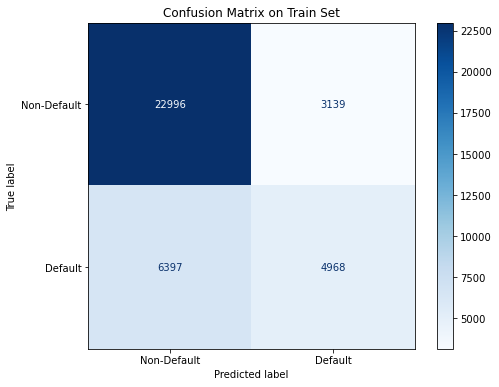

In [33]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve

fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(clf, X_train, Y_train, display_labels=['Non-Default', 'Default'], 
                      cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix on Train Set')
plt.show()

In [34]:
Y_train_pred = clf.predict(X_train)
Y_train_proba = clf.predict_proba(X_train)

print('Train Acc:', accuracy_score(Y_train, Y_train_pred))
print('Train F1:', f1_score(Y_train, Y_train_pred))
print('Train ROC AUC:', roc_auc_score(Y_train, Y_train_proba[:, 1]))

Train Acc: 0.7457066666666666
Train F1: 0.5102711585866885
Train ROC AUC: 0.7742958769952388


## Test Set Performance

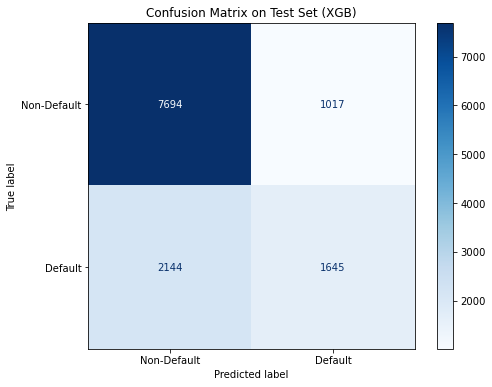

In [38]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve

fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(clf, X_test, Y_test, display_labels=['Non-Default', 'Default'], 
                      cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix on Test Set (XGB)')
plt.show()

In [36]:
# Predict on the test set
Y_test_pred = clf.predict(X_test)
Y_test_proba = clf.predict_proba(X_test)

print('test Acc:', accuracy_score(Y_test, Y_test_pred))
print('test F1:', f1_score(Y_test, Y_test_pred))
print('test ROC AUC:', roc_auc_score(Y_test, Y_test_proba[:, 1]))

test Acc: 0.74712
test F1: 0.5099984498527359
test ROC AUC: 0.7715460886647234


## ROC AUC

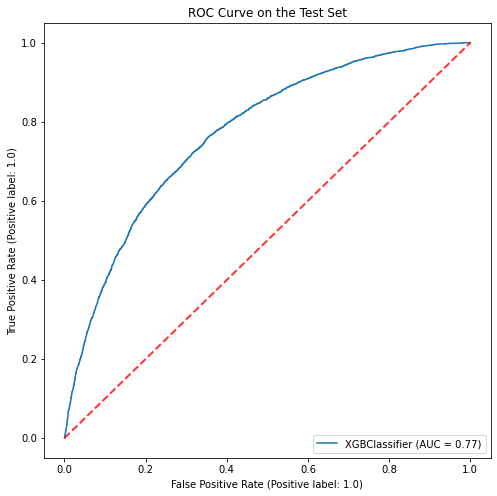

In [37]:
# ROC curve
fig, ax = plt.subplots(figsize=(8, 8))
plot_roc_curve(clf, X_test, Y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.set_title('ROC Curve on the Test Set')
plt.show()